### **Text emotion analysis**
- One of our challenge of this project is text emotion analysis task of nlp.

- Dataset: 'CARER: Contextualized Affect Representations for Emotion Recognition'.

# Install and Imports

In [2]:
#pip install 
!pip install scikit-learn -q
!pip install transformers -q


In [3]:
!pip install wandb -q
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.9 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import datasets
import matplotlib.pyplot as plt


from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from transformers import Trainer, TrainingArguments


# Data


In [5]:
#downloading data
df_validation = pd.read_csv('https://raw.githubusercontent.com/EunjinAn/M4_Ex/main/data/validation.csv')
df_train = pd.read_csv('https://raw.githubusercontent.com/EunjinAn/M4_Ex/main/data/training.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/EunjinAn/M4_Ex/main/data/test.csv')

In [6]:
print('Dataset information:')
print(f'Training data: {df_train.shape}')
print(f'Validation data: {df_validation.shape}')
print(f'Test data: {df_test.shape}')


Dataset information:
Training data: (16000, 2)
Validation data: (2000, 2)
Test data: (2000, 2)


In [7]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
df_train['label'].unique()

array([0, 3, 2, 5, 4, 1])

In [9]:
id2label = { 0: "sadness", 
            1: "joy",
            2: "love",
            3: "anger",
            4: "fear",
            5: "surprise"
}

In [10]:
id2label[0]

'sadness'

In [11]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
tokenizer.tokenize('I am eating an apple.')

['i', 'am', 'eating', 'an', 'apple', '.']

In [14]:
tokenizer('I am eating an apple.')

{'input_ids': [101, 1045, 2572, 5983, 2019, 6207, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
tokenizer(["I am eating an apple.", "We like banana."], padding = True, truncation = True, max_length =512)

{'input_ids': [[101, 1045, 2572, 5983, 2019, 6207, 1012, 102], [101, 2057, 2066, 15212, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0]]}

In [16]:
tokenizer.decode([101, 1045, 2572, 5983, 2019, 6207, 1012, 102])

'[CLS] i am eating an apple. [SEP]'

In [17]:
X_train= df_train['text'].to_list()
y_train = df_train['label'].to_list()

In [18]:
X_train[0], y_train[0]


('i didnt feel humiliated', 0)

In [19]:
X_test = df_test['text'].to_list()
y_test = df_test['label'].to_list()

In [20]:
X_test[0], y_test[0]

('im feeling rather rotten so im not very ambitious right now', 0)

In [21]:
X_validation = df_validation['text'].to_list()
y_validation = df_validation['label'].to_list()

In [22]:
X_validation[0], y_validation[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [23]:
X_train_tokenize = tokenizer(X_train, padding = True, truncation = True, max_length =512)

In [24]:
X_validation_tokenize = tokenizer(X_validation, padding = True, truncation = True, max_length =512)

In [25]:
X_test_tokenize = tokenizer(X_test, padding = True, truncation = True, max_length =512)

# Model

In [26]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [27]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [28]:
class SentimentDataset(torch.utils.data.Dataset):
  def __init__(self, tokenizeData, labels= None):
    self.tokenizeData = tokenizeData
    self.labels = labels

  def __len__(self):
    return len(self.tokenizeData['input_ids'])

  def __getitem__(self, index):
    item = {'input_ids' : torch.tensor(self.tokenizeData['input_ids'][index]),
            'token_type_ids' : torch.tensor(self.tokenizeData['token_type_ids'][index]),
            'attention_mask' : torch.tensor(self.tokenizeData['attention_mask'][index])}
    if self.labels : 
      item['labels'] = torch.tensor(self.labels[index])

    return(item)



In [29]:
trainDataset = SentimentDataset(X_train_tokenize, y_train)

In [ ]:
len(trainDataset)

16000

In [30]:
X_train_tokenize.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [31]:
trainDataset[0]

{'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0

In [32]:
validDataset = SentimentDataset(X_validation_tokenize, y_validation)

In [33]:
validDataset[0]

{'input_ids': tensor([  101, 10047,  3110,  3243,  6517,  1998,  3374,  2005,  2870,  2021,
          5665, 10245,  2041,  1997,  2009,  2574,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

# Train and validation


In [34]:
#Importing the necessary libraries
from huggingface_hub import notebook_login
from transformers import pipeline

#Login to Hugging Face account from the Jupyter notebook
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [35]:
def compute(m):
  predictions, labels = m
  predictions = np.argmax(predictions, axis = 1)
  accuracy = accuracy_score(y_true = labels, y_pred = predictions)
  f1 = f1_score(y_true = labels, y_pred = predictions, average = 'macro')
  return({'accuracy': accuracy,
        'f1': f1})

In [36]:
targs= TrainingArguments(output_dir = 'sentiment_analysis_bert',
                         per_device_train_batch_size = 16,
                         per_device_eval_batch_size = 16, 
                         num_train_epochs = 3, 
                         save_strategy= 'epoch', 
                         evaluation_strategy ='epoch', 
                         seed = 42, 
                         optim="adamw_torch",
                         load_best_model_at_end = True,   
                         report_to="wandb",
                         run_name='sentiment_analysis_bert',
                         push_to_hub=True)

In [39]:
%env WANDB_PROJECT=dk_sentiment_transformers

env: WANDB_PROJECT=dk_sentiment_transformers


In [40]:
trainer = Trainer(model = model, 
                  args = targs, 
                  train_dataset = trainDataset,
                  eval_dataset = validDataset,
                  compute_metrics= compute,
                  )

Cloning https://huggingface.co/Sadiksha/sentiment_analysis_bert into local empty directory.


In [41]:
trainer.train()

***** Running training *****
  Num examples = 16000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3000
  Number of trainable parameters = 109486854
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: sa73bi (sadiksha). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.227400,0.195410,0.923000,0.894631
2,0.121500,0.143888,0.935500,0.906367
3,0.077600,0.159409,0.944500,0.919524


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to sentiment_analysis_bert/checkpoint-1000
Configuration saved in sentiment_analysis_bert/checkpoint-1000/config.json
Model weights saved in sentiment_analysis_bert/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to sentiment_analysis_bert/checkpoint-2000
Configuration saved in sentiment_analysis_bert/checkpoint-2000/config.json
Model weights saved in sentiment_analysis_bert/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to sentiment_analysis_bert/checkpoint-3000
Configuration saved in sentiment_analysis_bert/checkpoint-3000/config.json
Model weights saved in sentiment_analysis_bert/checkpoint-3000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from sentimen

TrainOutput(global_step=3000, training_loss=0.2044591941833496, metrics={'train_runtime': 970.0157, 'train_samples_per_second': 49.484, 'train_steps_per_second': 3.093, 'total_flos': 2146076617536000.0, 'train_loss': 0.2044591941833496, 'epoch': 3.0})

# Test

In [42]:
testDataset = SentimentDataset(X_test_tokenize, y_test)

In [43]:
predictions, labels, results = trainer.predict(testDataset)
predictions = np.argmax(predictions, axis = 1)
results

***** Running Prediction *****
  Num examples = 2000
  Batch size = 16


{'test_loss': 0.15750513970851898,
 'test_accuracy': 0.936,
 'test_f1': 0.8937880162787445,
 'test_runtime': 8.1095,
 'test_samples_per_second': 246.625,
 'test_steps_per_second': 15.414}

In [44]:
matrix = confusion_matrix(y_true = labels, y_pred = predictions)

In [45]:
matrix

array([[571,   5,   0,   2,   3,   0],
       [  2, 648,  40,   2,   0,   3],
       [  0,   9, 149,   1,   0,   0],
       [ 13,   3,   0, 251,   8,   0],
       [  7,   0,   0,   4, 212,   1],
       [  2,   3,   1,   0,  19,  41]])

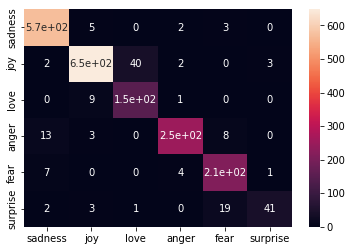

In [46]:
sns.heatmap(matrix, annot= True, xticklabels = id2label.values(), yticklabels = id2label.values())
plt.show()

In [47]:
id2label.values()

dict_values(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [48]:
def get_one_sentence(text):
  encoding = tokenizer(text, return_tensors="pt")
  outputs = model(**encoding.to("cuda")) 
  prediction_ids = outputs.logits.argmax(-1)
  prediction_label = id2label[prediction_ids.item()]
  return prediction_label

In [57]:
get_one_sentence('I am cheering my girlfriend.')

'joy'

In [50]:
trainer.push_to_hub('sentiment_analysis_bert') 

Saving model checkpoint to sentiment_analysis_bert
Configuration saved in sentiment_analysis_bert/config.json
Model weights saved in sentiment_analysis_bert/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/418M [00:00<?, ?B/s]

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/Sadiksha/sentiment_analysis_bert
   d08b4b8..74439f7  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Sadiksha/sentiment_analysis_bert
   d08b4b8..74439f7  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9445}, {'name': 'F1', 'type': 'f1', 'value': 0.9195237123156824}]}
To https://huggingface.co/Sadiksha/sentiment_analysis_bert
   74439f7..c5418aa  main -> main

   74439f7..c5418aa  main -> main



'https://huggingface.co/Sadiksha/sentiment_analysis_bert/commit/74439f7edb24d86a2c2efab0c273db8a2810178e'

In [51]:
#Pushing the trained model, trainer and dataset to the Hugging Face Hub
!pip install datasets -q
from datasets import load_dataset, Dataset, DatasetDict
model.push_to_hub('sentiment_analysis_bert')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 28.8 MB/s eta 0:00:00


Configuration saved in sentiment_analysis_bert/config.json
Model weights saved in sentiment_analysis_bert/pytorch_model.bin
Uploading the following files to Sadiksha/sentiment_analysis_bert: pytorch_model.bin,config.json


CommitInfo(commit_url='https://huggingface.co/Sadiksha/sentiment_analysis_bert/commit/314af7e1f0a7650bdc90e0d49f1644b1f4ea9f20', commit_message='Upload BertForSequenceClassification', commit_description='', oid='314af7e1f0a7650bdc90e0d49f1644b1f4ea9f20', pr_url=None, pr_revision=None, pr_num=None)

In [53]:
train_data = Dataset.from_dict(df_train)
test_data = Dataset.from_dict(df_test)
valid_data = Dataset.from_dict(df_validation)


In [54]:
dataset = DatasetDict({
    'train': train_data,
    'test': test_data,
    'valid': valid_data})

In [55]:
dataset.push_to_hub('sentiment_analysis_data')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

In [65]:
#pipeline
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
 
id2label = { 0: "sadness",  1:"joy", 2:"love", 3:"anger", 4:"fear", 5:"surprise" }
label2id = { "sadness":0, "joy":1, "love":2, "anger":3, "fear":4, "surprise":5}
 
 
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained("Sadiksha/sentiment_analysis_bert", id2label=id2label, label2id=label2id)
pipe = pipeline('sentiment-analysis', model = model, tokenizer=tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file to

In [66]:
pipe('I am happy')

[{'label': 'joy', 'score': 0.9992321729660034}]

In [67]:
!pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 10.3 MB/s eta 0:

#Gradio

In [68]:
import gradio as gr

In [71]:
def predict(text):
  return pipe(text)[0]['label']

iface = gr.Interface(
  fn=predict, 
  inputs='text',
  outputs='text',
  examples=[["I just received an unexpected gift from my friend and it made my day!"],
            ["I am feeling so lonely without my family around during the holidays."],
            ["I have a fear of spiders, they give me the creeps."]]
)

iface.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>